# Tool-less Agent Demo

This script demonstrates a minimal agentic AI experiment using:
- GPT5-nano model
- `HUCCT1_BILIARY_TRACT` cell line from the DepMap PRISM IC50 dataset

### Overview
- **Data Source**: Preprocessed PRISM secondary drug repurposing dataset (`processed_depmap_prism_ic50.csv`).  
- **Lookup & Dispatch**:  
  - `PrismLookup` retrieves IC50 values by drug and cell line identifiers.  
  - `PrismDispatchQueue` sequentially dispatches drug–cell line prediction tasks with optional shuffling.  
- **Agent**:  
  - A `dspy.Predict` agent configured with `PredictIC50DrugCell` signature.  
  - Operates without external tools (tool-less mode).  
  - Only makes predictions on the first 100 drugs and uses the smaller `openai/gpt-5-nano` model to reduce API usage.
- **Logging**:  
  - Each dispatched prediction is wrapped in a `TraceUnit`.  
  - Results (IC50 prediction, confidence, explanation, trajectory) are logged to JSONL under `analysis/log/toolless/<CCLE_NAME>/`.

### Purpose
This demo provides an example with agentic prediction pipelines in a **lab-in-the-loop (LITL)** context. 


In [1]:
from collections import OrderedDict
from pathlib import Path
import yaml
import os

import pandas as pd
import dspy
import matplotlib.pyplot as plt
from openai import OpenAI

from dspy_litl_agentic_system.tasks.prism_lookup import PrismLookup
from dspy_litl_agentic_system.tasks.task_dispatcher import PrismDispatchQueue
from dspy_litl_agentic_system.agent.signatures import PredictIC50DrugCell
from dspy_litl_agentic_system.agent.trace_unit import TraceUnit
from dspy_litl_agentic_system.utils.jsonl_log import append_jsonl
from dspy_litl_agentic_system.metrics import absolute_error, fold_error
from nbutils.pathing import project_file, repo_root
from nbutils.utils import IN_NOTEBOOK

if IN_NOTEBOOK:
    print("Running in IPython shell")
    from tqdm.notebook import tqdm
else:
    print("Running in standard Python shell")
    from tqdm.auto import tqdm

Running in IPython shell


### Parameters

In [2]:
N = 100 # for low API usage during demo
EXPERIMENTAL_DESCRIPTION = """
    The chemcial-peturbation viability screen is conducted in a 8-step, 
    4-fold dilution, starting from 10μM.
    """ # Adapted from PRISM description

UNIT = 'uM' # PRISM standard unit

CCLE_NAME = "HUCCT1_BILIARY_TRACT" # an arbitrary cell line for demo
SHUFFLE_QUEUE = True
SHUFFLE_SEED = 42
LM_CONFIG = {
    "model": "openai/gpt-5-nano", # small model for demo
    # Controls the randomness of the model's output (add variability to 
    # next token sampling). Lower values make the output more
    # deterministic, while higher values increase randomness.
    # A value of 1.0 is used here 
    # for the demo, balancing creativity and determinism.
    "temperature": 1.0, 
    "max_tokens": 20000,
    "seed": 42
}

### Processed Data and Logging path

In [3]:
git_root = repo_root()

all_data_path = Path(git_root) \
    / "data" / "processed" / "processed_depmap_prism_ic50.csv"
prism_all_data = pd.read_csv(all_data_path)

log_path = Path(git_root) \
    / "analysis" / "log" / "demo" / "toolless" / CCLE_NAME
log_path.mkdir(parents=True, exist_ok=True)

representation = f"step={N};ccle={CCLE_NAME};shuffle={SHUFFLE_QUEUE};" \
                 f"seed={SHUFFLE_SEED};"
representation += ';'.join(f"{key}={val}" \
                           for key, val in LM_CONFIG.items()).replace('/', '_')

log_file = log_path / f"{representation}.jsonl"
if log_file.exists():
    log_file.unlink()

### Validate Global Configurations

In [4]:
# --- Step 1: Locate config file ---
try:
    config_path = project_file("config.yml")
except NameError:
    config_path = Path(git_root) / "config.yml"

if not config_path.exists():
    raise FileNotFoundError(f"Config file not found at: {config_path}")

# --- Step 2: Load config.yml ---
with open(config_path, "r") as f:
    config = yaml.safe_load(f) or {}

# --- Step 3: Validate api section ---
api_cfg = config.get("api")
if not api_cfg:
    raise ValueError("Missing 'api' section in config.yml")

# Required keys
required = {"openai": "OPENAI_API_KEY"}

# --- Step 4: Collect resolved paths ---
rows, errors = [], []
for service, env_var in required.items():
    svc_cfg = api_cfg.get(service)

    if svc_cfg is None:
        rows.append((service, env_var, None, "Missing in config"))
        errors.append(f"Config for '{service}' is missing under 'api'")
        continue

    # Expect a structure like: api: { openai: { key: "..."} }
    key = svc_cfg.get("key")
    if not isinstance(key, str) or not key.strip():
        rows.append((service, env_var, None, "Missing 'key' or empty"))
        errors.append(f"Missing or empty 'key' for '{service}' in config.yml")
        continue

    # Set environment variable
    os.environ[env_var] = key
    status_str = "" 
    if os.getenv(env_var):
        status_str += "Exported"
        try:
            # use list models to validate key
            # avoids calling a model that may incur cost
            client = OpenAI(api_key=key)
            models = client.models.list()
        except Exception as e:
            status_str += f"& Error: {str(e)}"
        status_str += " & Validated"
    else:
        status_str += " Failed to export"

    rows.append((service, env_var, "********", status_str))

# --- Step 5: Display summary nicely ---
config_df = (
    pd.DataFrame(rows, columns=["Service", "Env Var", "Key (masked)", "Status"])
      .set_index("Service")
)
print(config_df)

# --- Step 6: Fail if any errors were collected ---
if errors:
    raise ValueError(
        "API config validation failed:\n" +
        "\n".join(f"- {e}" for e in errors) +
        "\nPlease refer to /config.yml.template for correct specification."
    )

                Env Var Key (masked)                Status
Service                                                   
openai   OPENAI_API_KEY     ********  Exported & Validated


### Initialize LooUp and Dispatcher class

In [5]:
lookup = PrismLookup(
    prism_all_data,
    drug_col="name",
    cell_col="ccle_name",
    ic50_col="ic50",
    casefold=False,
    validate_unique=True,
)
subset_lookup = lookup.subset(f"ccle_name == '{CCLE_NAME}'")
print(f"Subset size: {len(subset_lookup)}")

dispatcher = PrismDispatchQueue(
    subset_lookup,
    shuffle=True, # order of drugs is shuffled
    seed=42 # but reproducibile
)
dispatcher.has_next()

Subset size: 778


True

### Initialize LM 

In [6]:
dspy.configure(
    lm=dspy.LM(
        **LM_CONFIG
    ))
agent = dspy.Predict(
    PredictIC50DrugCell,
    tools=[]
)

### Loop across the subset of drugs and predict IC50 values
The run will be very quick as DSPy caches the lm output, 
when running for the first time this can take 10-20 mintues.

In [7]:
_n = min(N, dispatcher.remaining)

trace = OrderedDict()

for i in tqdm(
    range(_n), 
    desc="Running Agentic Predictions over Queue of Drugs",
    total=_n
    ):

    dispatch_item = dispatcher.dispatch()
    trace_unit = TraceUnit(
        drug=dispatch_item.drug,
        cell_line=dispatch_item.cell,
        experimental_description=EXPERIMENTAL_DESCRIPTION,
        output_unit=UNIT,
        ic50_true=dispatch_item.ic50
    )
    
    result = agent(
        drug=trace_unit.drug,
        cell_line=trace_unit.cell_line,
        experimental_description=trace_unit.experimental_description,
        output_unit=trace_unit.output_unit
    )

    trace_unit.ic50_pred = result.ic50_pred
    trace_unit.confidence = result.confidence
    trace_unit.explanation = result.explanation
    trace_unit.trajecory = result.trajectory if hasattr(result, 'trajectory') \
        else None

    trace[trace_unit.drug] = trace_unit
    
    # Log after each step for validation
    append_jsonl(log_file, record=trace_unit.model_dump())

Running Agentic Predictions over Queue of Drugs:   0%|          | 0/100 [00:00<?, ?it/s]

### Compute fold error and plot

As anticipated, our agent, without any external tools and memory, does not display improved predictive performance iterating over the task queue. 
There seemed to be a weak negative correlation between confidence and error evidence from the absolute error vs confidence plot. 

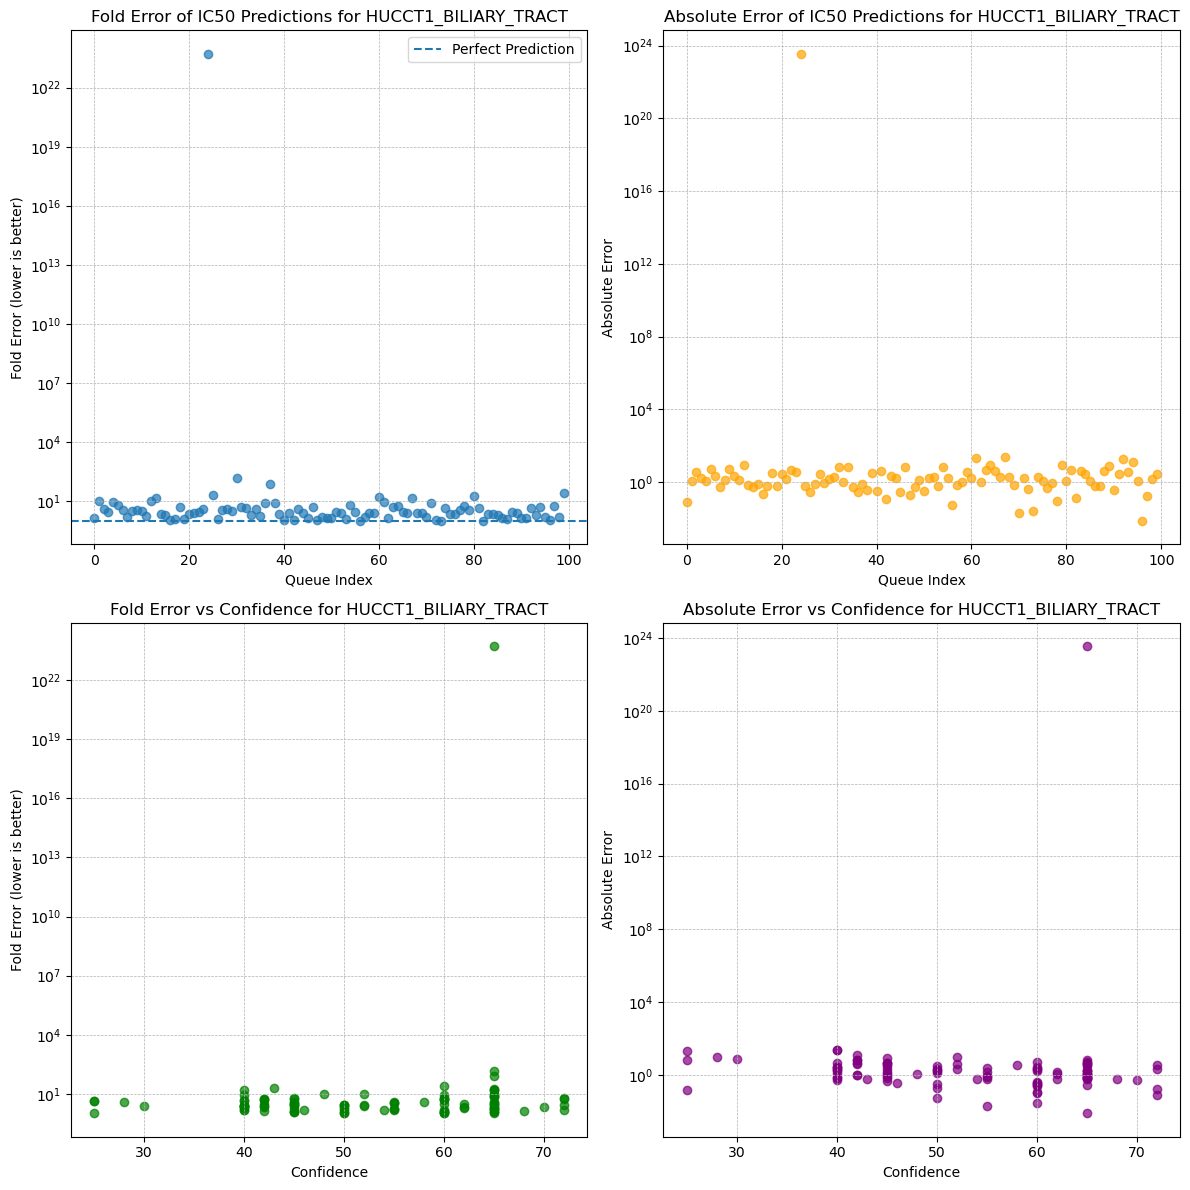

In [8]:
fold_errs = fold_error(
    [trace_unit.ic50_true for trace_unit in trace.values()],
    [trace_unit.ic50_pred for trace_unit in trace.values()],
    epsilon=1e-10
)
abs_errs = absolute_error(
    [trace_unit.ic50_true for trace_unit in trace.values()],
    [trace_unit.ic50_pred for trace_unit in trace.values()]
)

confidence = [
    trace_unit.confidence for trace_unit in trace.values()
]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot Fold Error
axs[0, 0].scatter(
    x=range(len(fold_errs)),
    y=fold_errs,
    alpha=0.7
)
axs[0, 0].set_yscale('log')
axs[0, 0].axhline(y=1, linestyle='--', label='Perfect Prediction', zorder=2)
axs[0, 0].set_xlabel('Queue Index')
axs[0, 0].set_ylabel('Fold Error (lower is better)')
axs[0, 0].set_title(f'Fold Error of IC50 Predictions for {CCLE_NAME}')
axs[0, 0].grid(True, which="both", ls="--", linewidth=0.5)
axs[0, 0].legend()

# Plot Absolute Error
axs[0, 1].scatter(
    x=range(len(abs_errs)),
    y=abs_errs,
    alpha=0.7,
    color='orange'
)
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlabel('Queue Index')
axs[0, 1].set_ylabel('Absolute Error')
axs[0, 1].set_title(f'Absolute Error of IC50 Predictions for {CCLE_NAME}')
axs[0, 1].grid(True, which="both", ls="--", linewidth=0.5)

# Plot Fold Error vs Confidence
axs[1, 0].scatter(
    x=confidence,
    y=fold_errs,
    alpha=0.7,
    color='green'
)
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlabel('Confidence')
axs[1, 0].set_ylabel('Fold Error (lower is better)')
axs[1, 0].set_title(f'Fold Error vs Confidence for {CCLE_NAME}')
axs[1, 0].grid(True, which="both", ls="--", linewidth=0.5)

# Plot Absolute Error vs Confidence
axs[1, 1].scatter(
    x=confidence,
    y=abs_errs,
    alpha=0.7,
    color='purple'
)
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('Confidence')
axs[1, 1].set_ylabel('Absolute Error')
axs[1, 1].set_title(f'Absolute Error vs Confidence for {CCLE_NAME}')
axs[1, 1].grid(True, which="both", ls="--", linewidth=0.5)

fig.tight_layout()

if IN_NOTEBOOK:
    plt.show()
else:
    print("Not in a notebook environment. Skipping plot display")

out_dir = repo_root() / "output" / "figures" / "demo"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "toolless_gpt5-nano_demo.png"

fig.savefig(out_path, dpi=300, bbox_inches='tight')
plt.close(fig)